In [1]:
import torch
from torchdiffeq import odeint as odeint
from torchdiffeq import odeint_event
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from modules import *

# Optimization

In [ ]:
y_init = -1
y_final = 1
x_bounds = (-0.5, 0.5)
z_bounds = (-0.5, 0.5)


# black hole configuration
BH_res = 4
positions = []
masses_presoftplus = np.ones((BH_res, BH_res, BH_res)) * (-15)

corner1 = (1, 1, 1)
corner2 = (2, 2, 2)     # center cube corners

# M_presoftplus = -4.6            # softplus(-4.6) = 0.01
# masses_presoftplus[corner1] = M_presoftplus
# masses_presoftplus[corner2] = M_presoftplus

masses_presoftplus = masses_presoftplus.flatten()
masses_presoftplus = masses_presoftplus + np.abs(np.random.normal(loc=0, scale=5, size=masses_presoftplus.shape))
# masses = torch.tensor(masses, dtype=torch.float32, requires_grad=True)



# masses = torch.zeros((4 ** 3), dtype=torch.float32)
x_coords = np.linspace(-0.5, 0.5, BH_res)
y_coords = np.linspace(-0.5, 0.5, BH_res)
z_coords = np.linspace(-0.5, 0.5, BH_res)   
for i, x in enumerate(x_coords):
    for j, y in enumerate(y_coords):
        for k, z in enumerate(z_coords):
            positions.append([x, y, z])

# positions = torch.tensor(positions, dtype=torch.float32)

# Image Pixle -----> initial xz
""" (69, 11) ------> tensor([0.1970, 1.1000, 0.3889])
    (22, 85) ------> tensor([-0.2778,  1.1000, -0.3586])
    (79, 90) ------> tensor([ 0.2980,  1.1000, -0.4091])
    (51, 52) ------> tensor([ 0.0152,  1.1000, -0.0253])
    (29, 16) ------> tensor([-0.2071,  1.1000,  0.3384])
    (65, 41) ------> tensor([0.1566, 1.1000, 0.0859])
    (49, 66) ------> tensor([-0.0051,  1.1000, -0.1667]) """

initial_xzs = [[0.1970, 0.3889], [-0.2778, -0.3586], [0.2980, -0.4091],
               [ 0.0152, -0.0253], [-0.2071,  0.3384], [0.1566, 0.0859],
               [0.0226, -0.2739]]
initial_xs = [[0, xz[0], y_init, xz[1]] for xz in initial_xzs]
initial_vs = [[0, 0, 1.0, 0] for xz in initial_xzs]
ray_labels = [(69, 11), (22, 85), (79, 90), (51, 52), (29, 16), (65, 41), (49, 66)]  # Using pixle coord. as label


# Image Pixle -----> geodesic endpoints
""" (69, 11) ------> tensor([0.1718, 1.0605, 0.2814])
    (22, 85) ------> tensor([-0.2075,  1.0649, -0.2499])
    (79, 90) ------> tensor([ 0.2540,  1.0788, -0.3618])
    (51, 52) ------> tensor([-0.0272,  1.0531, -0.0411])
    (29, 16) ------> tensor([-0.1610,  1.0706,  0.2795])
    (65, 41) ------> tensor([0.1574, 1.0317, 0.2279])
    (49, 66) ------> tensor([-0.1329,  1.0438, -0.1344])"""
final_xzs = [[np.float32(0.16694818), np.float32(0.28072944)],
 [np.float32(-0.20667507), np.float32(-0.23620655)],
 [np.float32(0.25112817), np.float32(-0.36125812)],
 [np.float32(-0.024412729), np.float32(-0.035667002)],
 [np.float32(-0.16540128), np.float32(0.27825055)],
 [np.float32(0.1669375), np.float32(0.24258697)],
 [np.float32(-0.05863329), np.float32(-0.19011398)]]

# final_xzs = np.load('y.npy')
y = [[0, xz[0], y_final, xz[1]] for xz in final_xzs]
y = np.array(y)
y = torch.tensor(y, dtype=torch.float32)

In [3]:
x0 = torch.tensor(initial_xs, dtype=torch.float64, requires_grad=True)
v0 = torch.tensor(initial_vs, dtype=torch.float64, requires_grad=True)
y0 = torch.stack([x0, v0])

In [4]:
# Terminating condition:
terminating_y = 1.0
terminating_v = 0.5

def terminate_func(t, y):
    flag = torch.ones(y.shape[1])
    for i in range(len(y[0])):
        if y[0][i][2] >= terminating_y:
            flag[i] = 0
    for i in range(len(y[0])):
        if torch.sum(torch.square(y[1][i][1:])) <= terminating_v:
            flag[i] = 0
    return flag

In [5]:
ODEfunc = NeuralODEfunc(positions=positions, masses_presoftplus=masses_presoftplus)
t = torch.linspace(0, 5, 10, requires_grad=True)

endpoints = []
for i in tqdm(range(y0.shape[1])):
    single_y0 = y0[:, i:i+1]
    t_final, y = odeint_event(ODEfunc, single_y0, torch.tensor([0.0]), event_fn=terminate_func, reverse_time=False, odeint_interface=odeint)
    endpoints.append(y[1])



  0%|                                                     | 0/7 [00:00<?, ?it/s]

0.0
0.0013782700855059708
0.0022236832055750264
0.0033355248083625395
0.008894732822300105
0.00988303646922234
0.01111841602787513
0.01111841602787513
0.033355248083625395
0.04447366411150053
0.10006574425087619
0.10994878072009853
0.12230257630662643
0.12230257630662643
0.1509732721597692
0.16530862008634056
0.23698535971919749
0.24972789120948313
0.2656560555723402
0.2656560555723402
0.14635477431206204
0.15838087331477985
0.21851136832836882
0.2292012341085624
0.24256356633380438
0.24256356633380438
0.26734812489508164
0.2797404041757203
0.3417018005789134
0.3527171599394811
0.3664863591401906
0.3664863591401906
0.2632357202538061
0.2735717972138069
0.3252521820138111
0.3344398059782563
0.3459243359338127
0.3459243359338127
0.36659648985381443
0.37693256681381526
0.42861295161381946
0.43780057557826463
0.44928510553382106
0.44928510553382106
0.47293078722872334
0.4847536280761745
0.54386783231343
0.5543770241778311
0.5675135140083322
0.5675135140083322
0.4694991100628255
0.479606112


 14%|██████▍                                      | 1/7 [00:00<00:05,  1.06it/s]

1.6502190849667269
1.6596895959343327
1.7070421507723619
1.715460382743567
1.7259831727075734
1.7259831727075734
1.7527204029593084
1.7660890180851758
1.8329320937145128
1.8448153071597282
1.8596693239662472
1.8596693239662472
1.8864065542179822
1.8997751693438496
1.9666182449731866
1.978501458418402
1.9933554752249212
1.9933554752249212
2.029000956272125
2.0468236967957267
2.1359373994137356
2.151779835434715
2.1715828804609387
2.1715828804609387
0.0
0.0012861540703927028
0.0022461886537792227
0.0033692829806688343
0.00898475461511689
0.009983060683463212
0.011230943268896112
0.011230943268896112
0.03369282980668834
0.044923773075584456
0.10107848942006503
0.11106155010352822
0.12354037595785723
0.12354037595785723
0.14976439674490738
0.16287640713843246
0.2284364591060578
0.24009157945585785
0.25466047989310786
0.25466047989310786
0.2884044152980319
0.3052763830004939
0.3896362215128039
0.4046335261372146
0.42338015691772785
0.42338015691772785
0.2743104405128351
0.28413542082269866



 29%|████████████▊                                | 2/7 [00:01<00:04,  1.15it/s]

1.5465916910855542
1.5809172347027323
1.5980800065113212
1.6838938655542657
1.6991496627174558
1.7182194091714431
1.7182194091714431
1.7525449527886212
1.7697077245972102
1.8555215836401546
1.8707773808033448
1.889847127257332
1.889847127257332
1.9284239113075037
1.9477123033325894
2.044154263458018
2.0612995008136497
2.082731047508189
2.082731047508189
2.1275078238081773
2.149896211958171
2.2618381527081404
2.2817389421748016
2.306614929008128
2.306614929008128
0.0
0.00113485859513712
0.0017518755571131516
0.002627813335669727
0.007007502228452606
0.007786113587169561
0.008759377785565755
0.008759377785565755
0.02627813335669727
0.03503751114226303
0.07883440007009182
0.08662051365726137
0.0963531556412233
0.0963531556412233
0.12161640662003975
0.13424803210944797
0.19740615955648905
0.20863427110262966
0.22266941053530545
0.22266941053530545



 43%|███████████████████▎                         | 3/7 [00:02<00:02,  1.66it/s]

0.11659942613156797
0.1267225613767403
0.17733823760260192
0.1863365800427551
0.19758450809294656
0.19758450809294656
0.21822460638951574
0.22854465553780035
0.28014490127922326
0.28931827829992063
0.30078499957579236
0.30078499957579236
0.21316873295478259
0.22096084538570057
0.2599214075402906
0.26684772970110654
0.2755056324021265
0.2755056324021265
0.29155588631674395
0.2995810132740527
0.33970664806059614
0.34684009424487056
0.3557569019752135
0.3557569019752135
0.28959635067533657
0.2966417098119416
0.3318685054949666
0.3381310469497266
0.34595922376817656
0.34595922376817656
0.3602231333641435
0.367355088162127
0.40301486215204424
0.4093543775280295
0.4172787717480111
0.4172787717480111
0.43154268134397805
0.4386746361419615
0.47433441013187877
0.48067392550786403
0.4885983197278456
0.4885983197278456
0.0
0.0010413188825863643
0.002113374161392339
0.003170061242088508
0.008453496645569356
0.009392774050632617
0.010566870806961693
0.010566870806961693
0.03170061242088509
0.042267


 57%|█████████████████████████▋                   | 4/7 [00:02<00:01,  1.53it/s]

1.6681295759506987
1.6681295759506987
1.557336442394831
1.5685553265346805
1.6246497472339279
1.6346220886915717
1.6470875155136264
1.6470875155136264
1.6695252837933254
1.680744167933175
1.7368385886324222
1.746810930090066
1.7592763569121208
1.7592763569121208
1.7912718096798586
1.8072695360637274
1.8872581679830716
1.9014783692131771
1.9192536207508089
1.9192536207508089
1.9664960680721049
1.9901172917327528
2.1082234100359925
2.1292200532899015
2.155465857357288
2.155465857357288
0.0
0.0017103966509077312
0.0023978399503556615
0.003596759925533492
0.009591359801422646
0.010657066446025161
0.011989199751778305
0.011989199751778305
0.03596759925533492
0.04795679900711322
0.10790279776600477
0.11855986421202992
0.13188119726956135
0.13188119726956135
0.15804313939116635
0.17112411045196885
0.23652896575598129
0.24815649558780573
0.2626909078775862
0.2626909078775862
0.15308319125072883
0.1636841882413126
0.21668917319423125
0.22611228163030567
0.23789116717539868
0.23789116717539868
0


 71%|████████████████████████████████▏            | 5/7 [00:03<00:01,  1.23it/s]

1.600287813646631
1.6047541250186605
1.6270856818788078
1.6310557364317229
1.6360183046228665
1.6360183046228665
1.6456632727045808
1.6504857567454378
1.6745981769497231
1.678884829430485
1.684243145031437
1.684243145031437
1.6938881131131514
1.6987105971540084
1.7228230173582937
1.7271096698390556
1.7324679854400076
1.7324679854400076
1.744584124347472
1.7506421938012042
1.780932541069865
1.7863174916954048
1.793048679977329
1.793048679977329
1.8106865081719725
1.8195054222692941
1.8635999927559024
1.871439027509077
1.8812378209505454
1.8812378209505454
1.9006672499278818
1.9103819644165498
1.95895553685989
1.967590838627595
1.9783849658372261
1.9783849658372261
2.005371272963219
2.0188644265262154
2.0863301943411967
2.098324108619416
2.113316501467189
2.113316501467189
0.0
0.0011733783734821925
0.002098112289161116
0.003147168433741674
0.008392449156644465
0.009324943507382737
0.010490561445805579
0.010490561445805579
0.03147168433741675
0.04196224578322232
0.09441505301225024
0.1037


 86%|██████████████████████████████████████▌      | 6/7 [00:04<00:00,  1.30it/s]

2.0382384630143884
2.056588418016955
2.079525861770162
2.079525861770162
2.137299129139955
2.1661857628248513
2.3106189312493317
2.3362959389692395
2.368392198619124
2.368392198619124
0.0
0.0009507485840047199
0.001917331670529463
0.0028759975057941947
0.007669326682117852
0.008521474091242058
0.009586658352647314
0.009586658352647314
0.028759975057941947
0.03834663341058926
0.08627992517382584
0.09480139926506788
0.10545324187912045
0.10545324187912045
0.12963715306792617
0.14172910866232902
0.2021888866343433
0.21293729160714583
0.22637279782314898
0.22637279782314898
0.2505567090119547
0.26264866460635755
0.32310844257837185
0.3338568475511744
0.3472923537671775
0.3472923537671775
0.37147626495598324
0.3835682205503861
0.4440279985224004
0.45477640349520293
0.468211909711206
0.468211909711206
0.492593286244874
0.5047839745117079
0.5657374158458777
0.5765735831941745
0.5901187923795453
0.5901187923795453
0.6157769946184016
0.6286060957378298
0.6927516013349702
0.7041552467744618
0.71

100%|█████████████████████████████████████████████| 7/7 [00:05<00:00,  1.36it/s]

2.226308859724721
2.226308859724721
2.2890425520070976
2.320409398148286
2.477243628854226
2.5051252698686155
2.539977321136602
2.539977321136602


In [5]:
def plot_forward(forward_result):
    xzs = forward_result[:, [1, 3]].cpu().detach().numpy()
    xs = xzs[:, 0]
    zs = xzs[:, 1]
    plt.figure(figsize=(4, 4))
    plt.scatter(xs, zs, color='b')
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
    plt.show()

In [9]:
target = torch.tensor([[0, xz[0], y_final, xz[1]] for xz in final_xzs])

In [10]:
def loss(target, y):
    return torch.sum(torch.square(target - y))

## Adjoint Method

In [11]:
from torchdiffeq import odeint_adjoint

In [12]:
ODEfunc = NeuralODEfunc(positions=positions, masses_presoftplus=masses_presoftplus)

endpoints = []
for i in tqdm(range(y0.shape[1])):
    single_y0 = y0[:, i:i+1]
    t_final, y = odeint_event(ODEfunc, single_y0, torch.tensor([0.0]), event_fn=terminate_func, reverse_time=False, odeint_interface=odeint_adjoint)
    endpoints.append(y[1])

100%|█████████████████████████████████████████████| 7/7 [00:03<00:00,  1.89it/s]


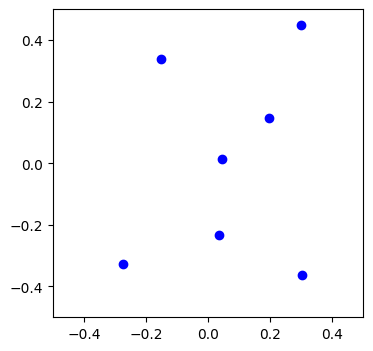

In [13]:
y = torch.stack(endpoints, dim=1).squeeze()
plot_forward(y[0, :])

In [ ]:
import math
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

class LinearWarmup(_LRScheduler):
    def __init__(self, optimizer, warmup_epochs, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        epoch = self.last_epoch
        if epoch < self.warmup_epochs:
            scale = epoch / self.warmup_epochs
        else:
            scale = 1.0

        return [base_lr * scale for base_lr in self.base_lrs]

In [12]:
optimizer = torch.optim.Adam([ODEfunc.metric_field.masses_presoftplus], lr=1.0)
warmup_epochs = 20
warmup_scheduler = LinearWarmup(optimizer, warmup_epochs=warmup_epochs)
plateau_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True, min_lr=0.01)


losses = []
lrs = []

for epoch in range(0, 600):
    optimizer.zero_grad()              
    endpoints = []
    for i in tqdm(range(y0.shape[1])):
        single_y0 = y0[:, i:i+1]
        t_final, single_y = odeint_event(ODEfunc, single_y0, torch.tensor([0.0]), event_fn=terminate_func, reverse_time=False, odeint_interface=odeint)
        endpoints.append(single_y[1])
        
    y = torch.stack(endpoints, dim=1).squeeze()
    l = loss(target, y[0, :])
    plot_forward(y[0, :])
    
    
    l.backward()
    optimizer.step()
    
    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        plateau_scheduler.step(l)
        
    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)
    losses.append(l.item())
    print(f"Epoch {epoch+1}: Loss={l:.6f}, LR={current_lr:.6f}")

NameError: name 'LinearWarmup' is not defined

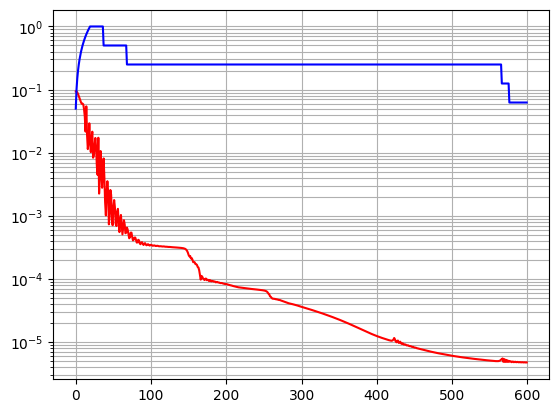

In [17]:
plt.plot(losses, color='r')
plt.plot(lrs, color='b')
plt.yscale('log')
plt.grid(True, which="both", ls="-")
plt.show()

In [ ]:
np.savez(__AVOID_OVERWRITE__, loss=losses, lr=lrs,
         masses_presoftplus=ODEfunc.metric_field.masses_presoftplus.cpu().detach().numpy())

In [19]:
torch.nn.functional.softplus(ODEfunc.metric_field.masses_presoftplus)

tensor([1.0128e-08, 7.7134e-06, 7.0468e-05, 1.7490e-04, 1.4858e-09, 2.1692e-06,
        3.9159e-05, 1.3907e-04, 5.0920e-11, 6.1449e-05, 3.6773e-05, 6.6398e-06,
        1.0653e-08, 2.4232e-03, 2.3529e-04, 2.1645e-06, 3.1072e-06, 7.0897e-05,
        7.0863e-06, 7.4065e-04, 5.9678e-05, 2.7073e-03, 2.3508e-06, 1.4536e-04,
        1.0267e-06, 2.4638e-03, 6.2163e-06, 2.2744e-04, 5.2044e-08, 1.0807e-02,
        2.3682e-03, 4.3093e-05, 1.1451e-09, 4.4894e-08, 4.9154e-05, 4.4239e-09,
        2.0375e-08, 4.8094e-05, 6.0103e-06, 4.0862e-07, 1.9690e-08, 2.1731e-09,
        2.1835e-03, 1.0494e-06, 1.9938e-03, 9.5144e-06, 1.0114e-02, 2.3537e-09,
        3.5595e-07, 2.4718e-06, 7.2977e-04, 9.6864e-08, 3.0559e-08, 7.8411e-09,
        1.0936e-04, 2.2706e-06, 4.9065e-08, 1.4247e-05, 4.8747e-04, 7.1845e-08,
        2.4734e-09, 2.8496e-03, 1.1268e-05, 3.8605e-04],
       grad_fn=<SoftplusBackward0>)

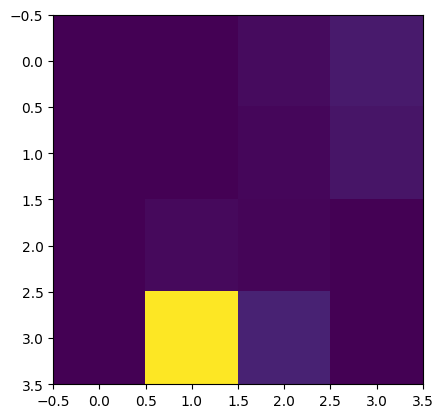

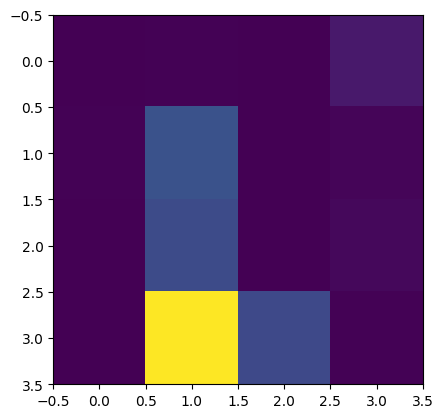

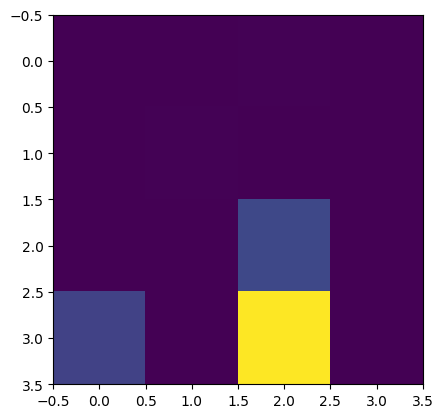

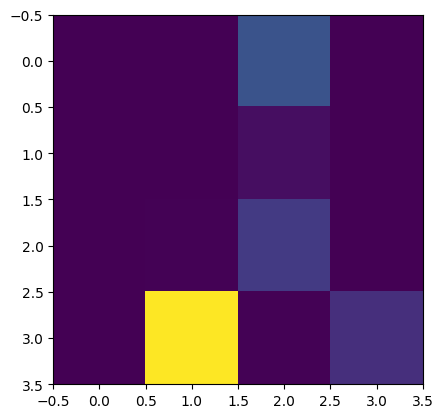

In [20]:
masses_reshaped = torch.nn.functional.softplus(ODEfunc.metric_field.masses_presoftplus).cpu().detach().numpy().reshape((4, 4, 4))
masses_swapped = np.swapaxes(masses_reshaped, 1, 2)
for i in range(4):
    plt.imshow(masses_reshaped[i])
    plt.show()

## FTLE

In [6]:
import torch
from torchdiffeq import odeint as odeint
from torchdiffeq import odeint_event
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from modules import *

In [ ]:

y_init = -1
y_final = 1
x_bounds = (-0.5, 0.5)
z_bounds = (-0.5, 0.5)


#  black hole configuration
BH_res = 4
positions = []

# masses = np.zeros((BH_res, BH_res, BH_res))

# corner1 = (1, 1, 1)
# corner2 = (2, 2, 2)

# M = 0.01            
# masses[corner1] = M
# masses[corner2] = M

# masses = masses.flatten()
# masses = masses + np.random.rand(len(masses)) * 0.0
# masses = torch.tensor(masses, dtype=torch.float32, requires_grad=True)

masses_presoftplus = np.ones((BH_res, BH_res, BH_res)) * (-15)
corner1 = (1, 1, 1)
corner2 = (2, 2, 2)
M_presoftplus = -4.6            # softplus(-4.6) = 0.01
masses_presoftplus[corner1] = M_presoftplus
masses_presoftplus[corner2] = M_presoftplus
masses_presoftplus = masses_presoftplus.flatten()
masses_presoftplus = masses_presoftplus + np.random.rand(len(masses_presoftplus)) * 1e-5



# masses = torch.zeros((4 ** 3), dtype=torch.float32)
x_coords = np.linspace(-0.5, 0.5, BH_res)
y_coords = np.linspace(-0.5, 0.5, BH_res)
z_coords = np.linspace(-0.5, 0.5, BH_res)  
for i, x in enumerate(x_coords):
    for j, y in enumerate(y_coords):
        for k, z in enumerate(z_coords):
            positions.append([x, y, z])

# positions = torch.tensor(positions, dtype=torch.float32)

# Image Pixle -----> initial xz
""" (69, 11) ------> tensor([0.1970, 1.1000, 0.3889])
    (22, 85) ------> tensor([-0.2778,  1.1000, -0.3586])
    (79, 90) ------> tensor([ 0.2980,  1.1000, -0.4091])
    (51, 52) ------> tensor([ 0.0152,  1.1000, -0.0253])
    (29, 16) ------> tensor([-0.2071,  1.1000,  0.3384])
    (65, 41) ------> tensor([0.1566, 1.1000, 0.0859])
    (49, 66) ------> tensor([-0.0051,  1.1000, -0.1667]) """

initial_xzs = [[0.1970, 0.3889], [-0.2778, -0.3586], [0.2980, -0.4091],
               [ 0.0152, -0.0253], [-0.2071,  0.3384], [0.1566, 0.0859],
               [0.0226, -0.2739]]
initial_xs = [[0, xz[0], y_init, xz[1]] for xz in initial_xzs]
initial_vs = [[0, 0, 1.0, 0] for xz in initial_xzs]
ray_labels = [(69, 11), (22, 85), (79, 90), (51, 52), (29, 16), (65, 41), (49, 66)]  # Using pixle coord. as label


# Image Pixle -----> geodesic endpoints
""" (69, 11) ------> tensor([0.1718, 1.0605, 0.2814])
    (22, 85) ------> tensor([-0.2075,  1.0649, -0.2499])
    (79, 90) ------> tensor([ 0.2540,  1.0788, -0.3618])
    (51, 52) ------> tensor([-0.0272,  1.0531, -0.0411])
    (29, 16) ------> tensor([-0.1610,  1.0706,  0.2795])
    (65, 41) ------> tensor([0.1574, 1.0317, 0.2279])
    (49, 66) ------> tensor([-0.1329,  1.0438, -0.1344])"""
final_xzs = [[np.float32(0.16694818), np.float32(0.28072944)],
 [np.float32(-0.20667507), np.float32(-0.23620655)],
 [np.float32(0.25112817), np.float32(-0.36125812)],
 [np.float32(-0.024412729), np.float32(-0.035667002)],
 [np.float32(-0.16540128), np.float32(0.27825055)],
 [np.float32(0.1669375), np.float32(0.24258697)],
 [np.float32(-0.05863329), np.float32(-0.19011398)]]

# final_xzs = np.load('y.npy')
y = [[0, xz[0], y_final, xz[1]] for xz in final_xzs]
y = np.array(y)
y = torch.tensor(y, dtype=torch.float32)

x0 = torch.tensor(initial_xs, dtype=torch.float64, requires_grad=True)
v0 = torch.tensor(initial_vs, dtype=torch.float64, requires_grad=True)
y0 = torch.stack([x0, v0])

In [8]:
# Terminating condition:
terminating_y = 1.0
terminating_v = 0.5

def terminate_func(t, y):
    flag = torch.ones(y.shape[1])
    for i in range(len(y[0])):
        if y[0][i][2] >= terminating_y:
            flag[i] = 0
    for i in range(len(y[0])):
        if torch.sum(torch.square(y[1][i][1:])) <= terminating_v:
            flag[i] = 0
    return flag

In [9]:
from torchdiffeq import odeint_adjoint
from torchdiffeq import odeint_event

In [10]:
ODEfunc = NeuralODEfunc(positions=positions, masses_presoftplus=masses_presoftplus)

endpoints = []
for i in tqdm(range(y0.shape[1])):
    single_y0 = y0[:, i:i+1]
    t_final, y = odeint_event(ODEfunc, single_y0, torch.tensor([0.0]), event_fn=terminate_func, reverse_time=False, odeint_interface=odeint_adjoint)
    endpoints.append(y[1])

100%|█████████████████████████████████████████████| 7/7 [00:06<00:00,  1.16it/s]


In [11]:
target = torch.tensor([[0, xz[0], y_final, xz[1]] for xz in final_xzs])
def loss(target, y):
    return torch.sum(torch.square(target - y))

100%|█████████████████████████████████████████████| 7/7 [00:12<00:00,  1.75s/it]


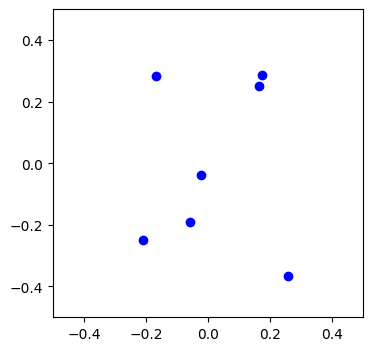

Epoch 1: Loss=0.000466


100%|█████████████████████████████████████████████| 7/7 [00:28<00:00,  4.12s/it]


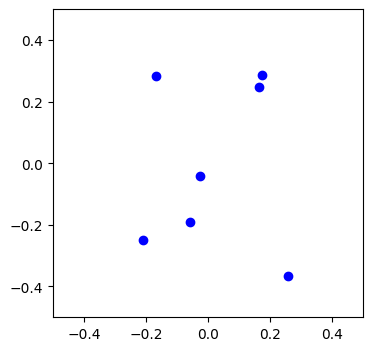

Epoch 2: Loss=0.000426


100%|█████████████████████████████████████████████| 7/7 [00:24<00:00,  3.45s/it]


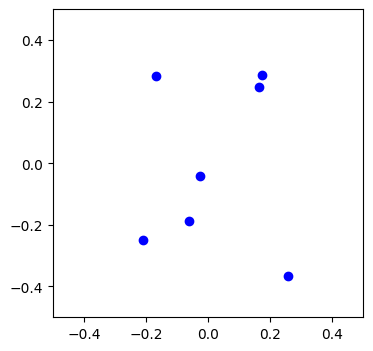

Epoch 3: Loss=0.000386


100%|█████████████████████████████████████████████| 7/7 [00:28<00:00,  4.08s/it]


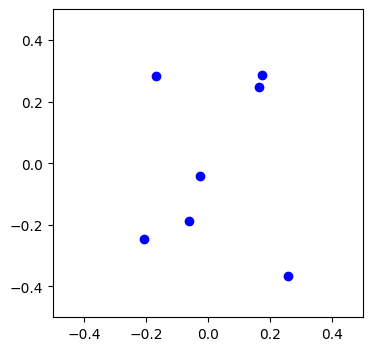

Epoch 4: Loss=0.000355


100%|█████████████████████████████████████████████| 7/7 [00:28<00:00,  4.06s/it]


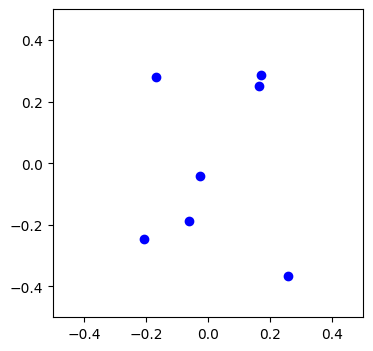

Epoch 5: Loss=0.000336


100%|█████████████████████████████████████████████| 7/7 [00:27<00:00,  3.91s/it]


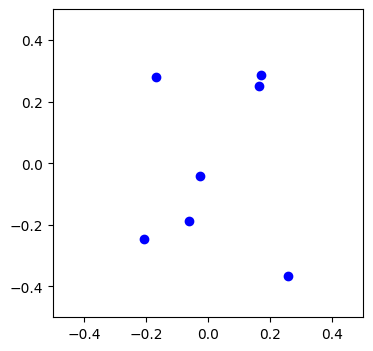

Epoch 6: Loss=0.000326


100%|█████████████████████████████████████████████| 7/7 [00:37<00:00,  5.33s/it]


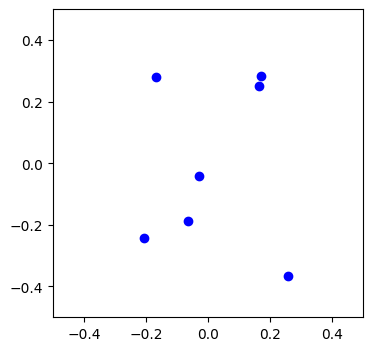

Epoch 7: Loss=0.000322


100%|█████████████████████████████████████████████| 7/7 [00:30<00:00,  4.30s/it]


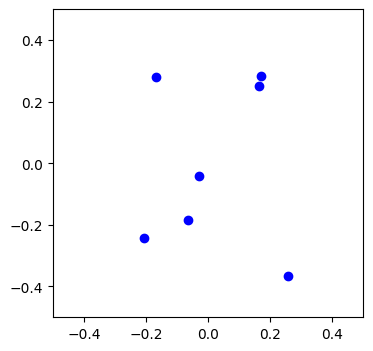

Epoch 8: Loss=0.000322


100%|█████████████████████████████████████████████| 7/7 [00:29<00:00,  4.17s/it]


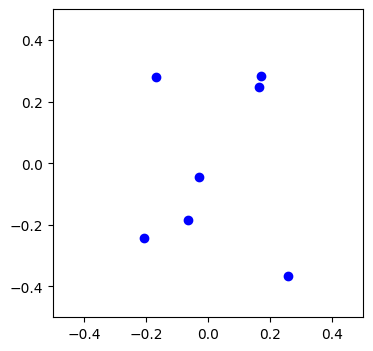

Epoch 9: Loss=0.000327


100%|█████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]


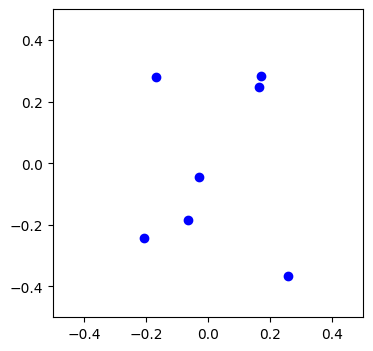

Epoch 10: Loss=0.000334


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.38s/it]


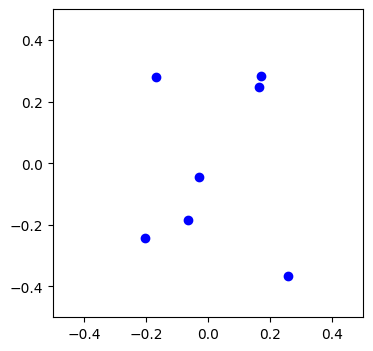

Epoch 11: Loss=0.000340


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.39s/it]


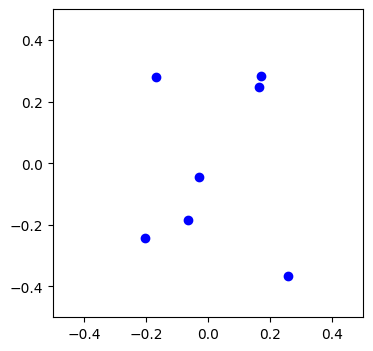

Epoch 12: Loss=0.000343


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.33s/it]


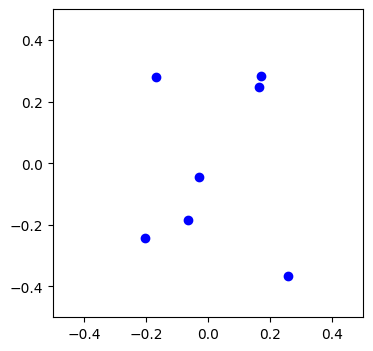

Epoch 13: Loss=0.000343


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


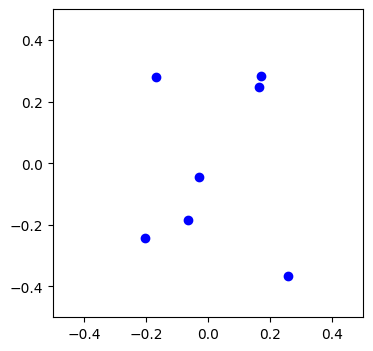

Epoch 14: Loss=0.000341


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


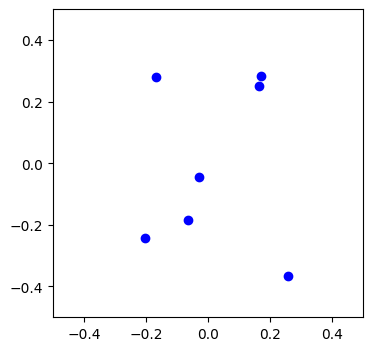

Epoch 15: Loss=0.000338


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


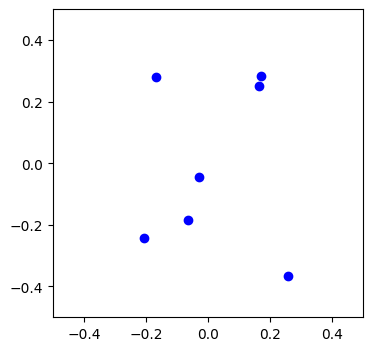

Epoch 16: Loss=0.000334


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


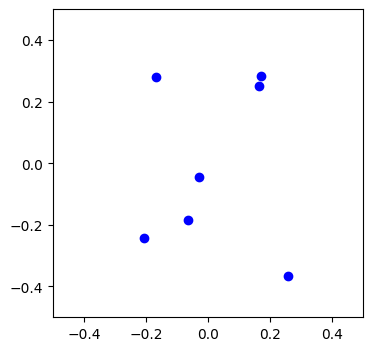

Epoch 17: Loss=0.000329


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


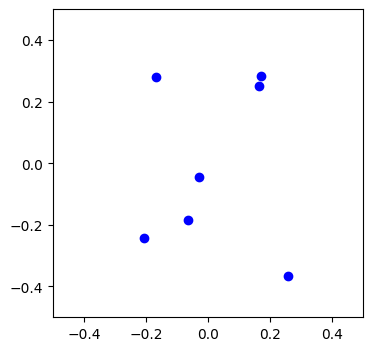

Epoch 18: Loss=0.000325


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


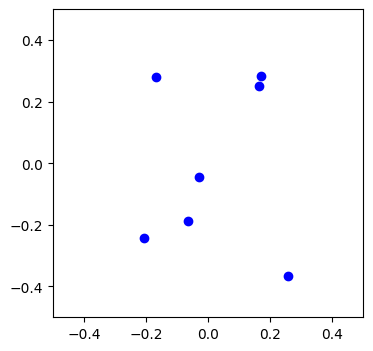

Epoch 19: Loss=0.000321


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


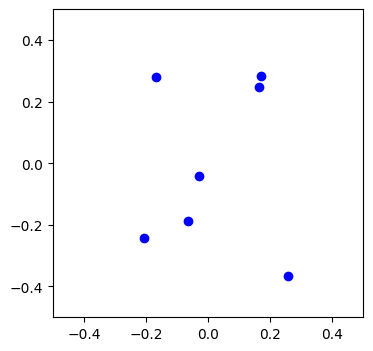

Epoch 20: Loss=0.000320


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.25s/it]


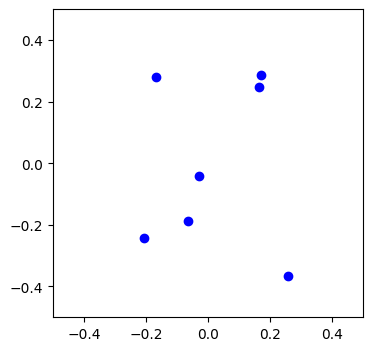

Epoch 21: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.35s/it]


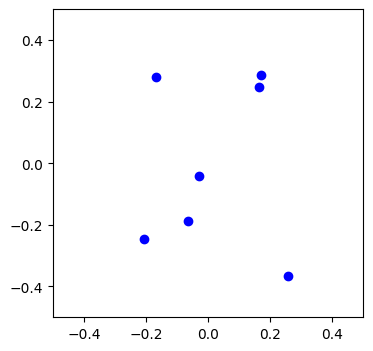

Epoch 22: Loss=0.000320


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


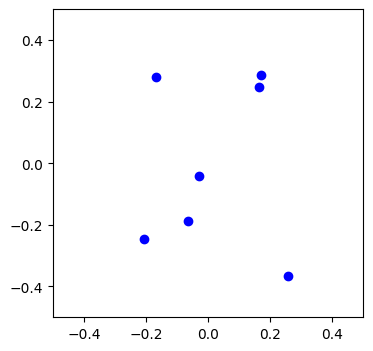

Epoch 23: Loss=0.000321


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


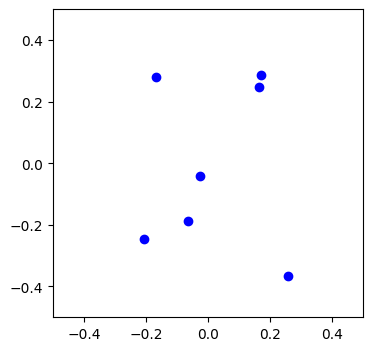

Epoch 24: Loss=0.000322


100%|█████████████████████████████████████████████| 7/7 [00:11<00:00,  1.59s/it]


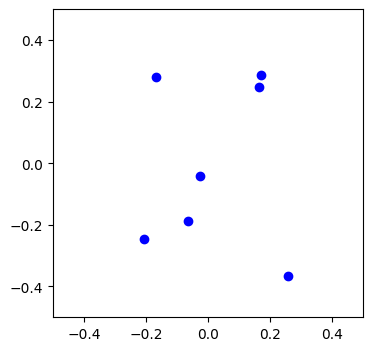

Epoch 25: Loss=0.000324


100%|█████████████████████████████████████████████| 7/7 [00:11<00:00,  1.63s/it]


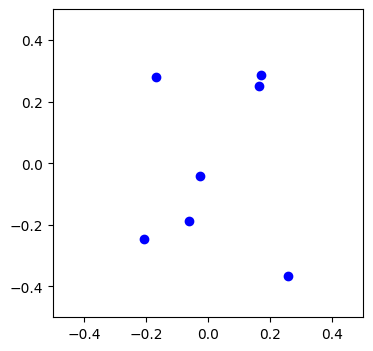

Epoch 26: Loss=0.000325


100%|█████████████████████████████████████████████| 7/7 [00:11<00:00,  1.61s/it]


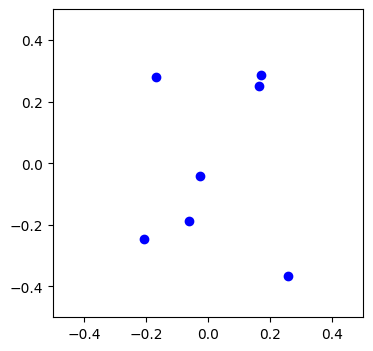

Epoch 27: Loss=0.000325


100%|█████████████████████████████████████████████| 7/7 [00:10<00:00,  1.53s/it]


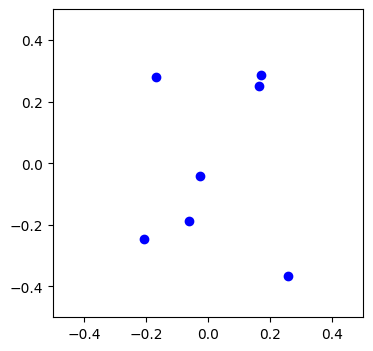

Epoch 28: Loss=0.000324


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


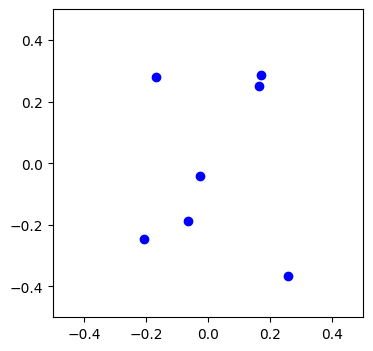

Epoch 29: Loss=0.000323


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.39s/it]


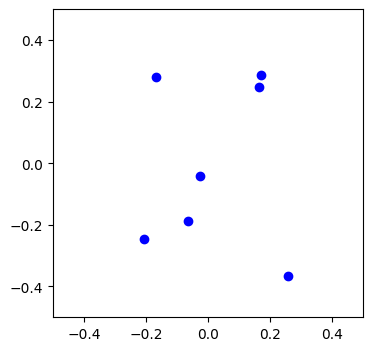

Epoch 30: Loss=0.000322


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


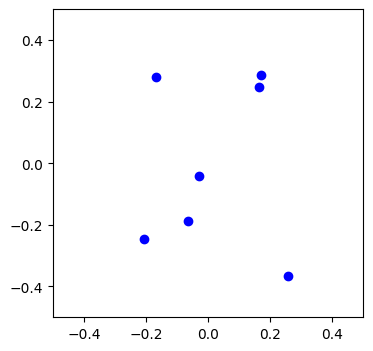

Epoch 31: Loss=0.000321


100%|█████████████████████████████████████████████| 7/7 [00:12<00:00,  1.81s/it]


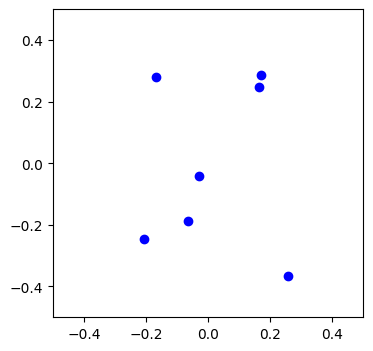

Epoch 32: Loss=0.000320


100%|█████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]


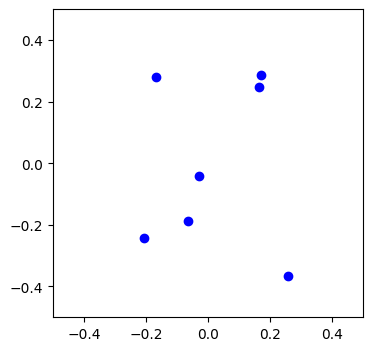

Epoch 33: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.39s/it]


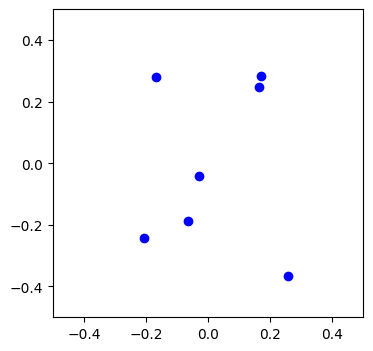

Epoch 34: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.41s/it]


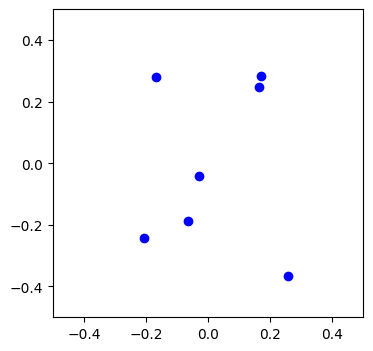

Epoch 35: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.39s/it]


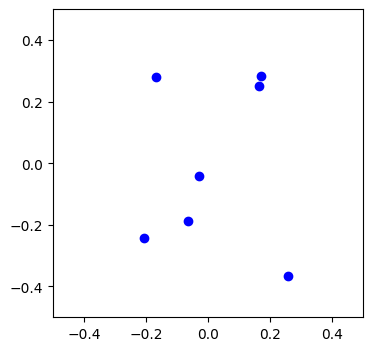

Epoch 36: Loss=0.000320


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.41s/it]


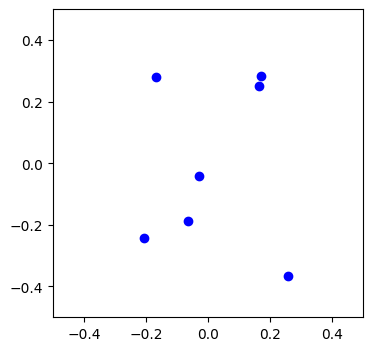

Epoch 37: Loss=0.000320


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.40s/it]


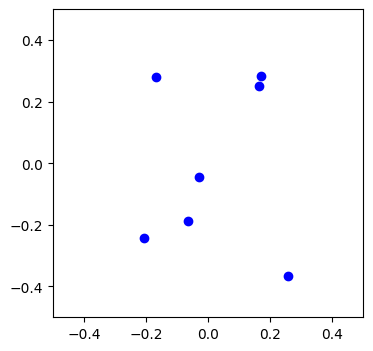

Epoch 38: Loss=0.000321


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


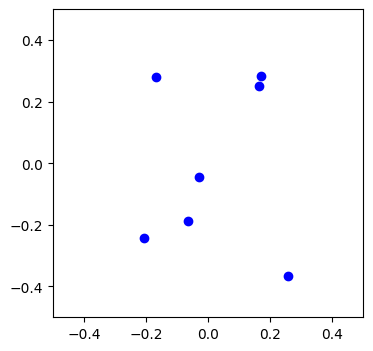

Epoch 39: Loss=0.000321


100%|█████████████████████████████████████████████| 7/7 [00:10<00:00,  1.52s/it]


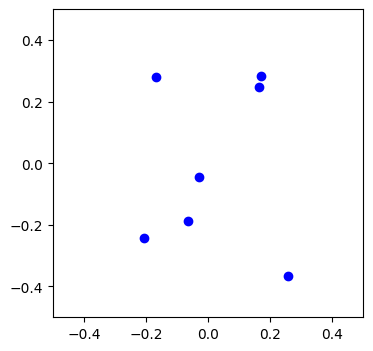

Epoch 40: Loss=0.000321


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.36s/it]


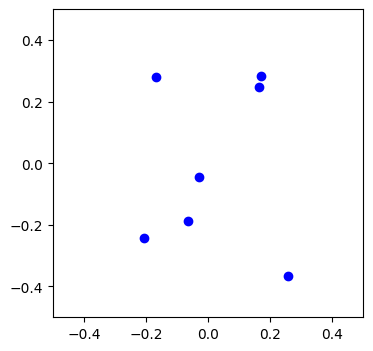

Epoch 41: Loss=0.000320


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


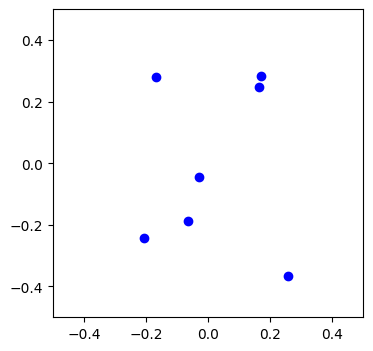

Epoch 42: Loss=0.000320


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.36s/it]


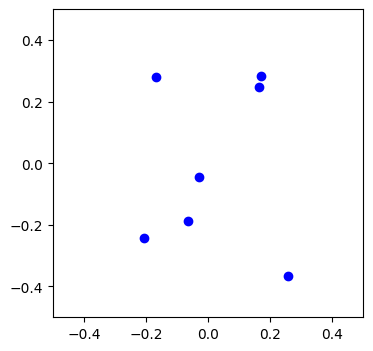

Epoch 43: Loss=0.000320


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


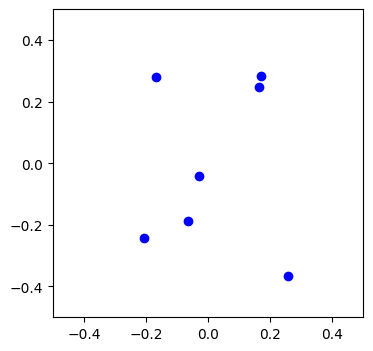

Epoch 44: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


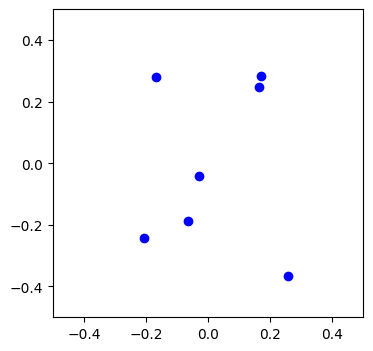

Epoch 45: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.23s/it]


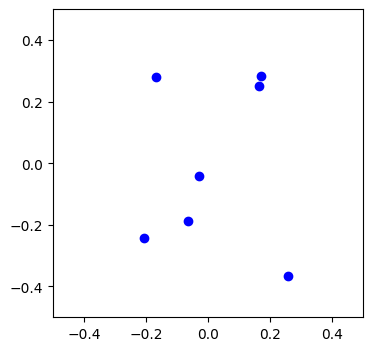

Epoch 46: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


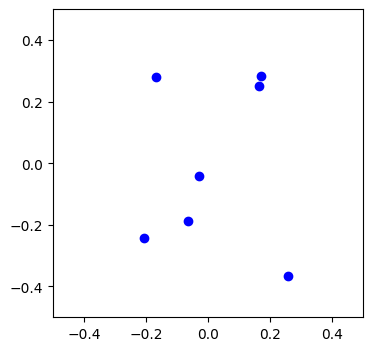

Epoch 47: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.37s/it]


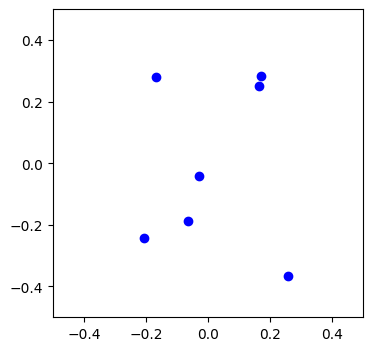

Epoch 48: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:10<00:00,  1.43s/it]


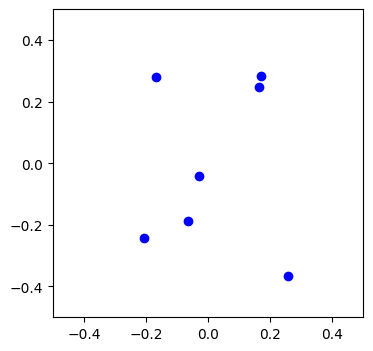

Epoch 49: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.39s/it]


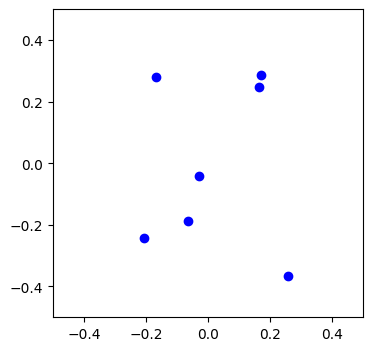

Epoch 50: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


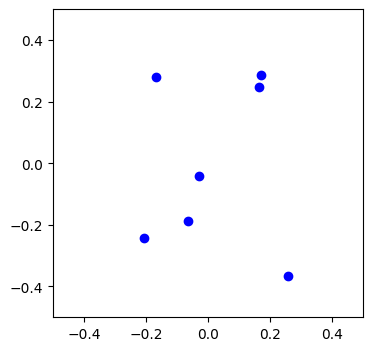

Epoch 51: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.42s/it]


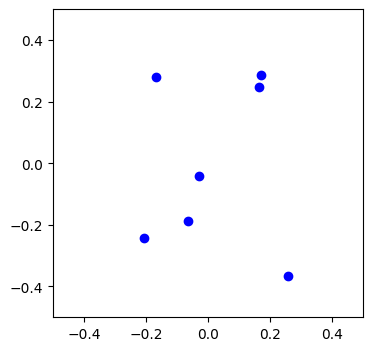

Epoch 52: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.43s/it]


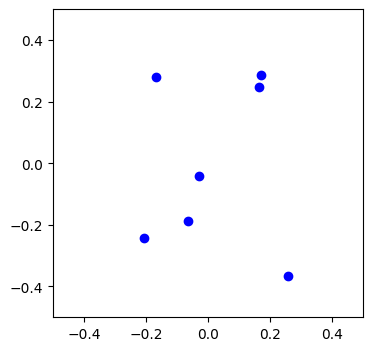

Epoch 53: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.20s/it]


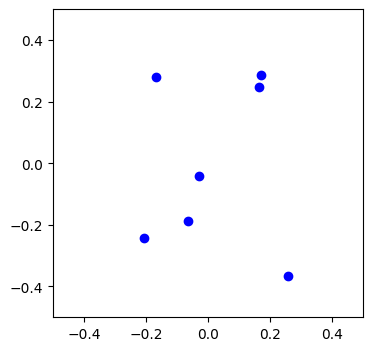

Epoch 54: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.42s/it]


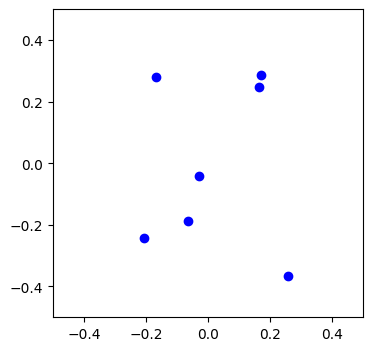

Epoch 55: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.18s/it]


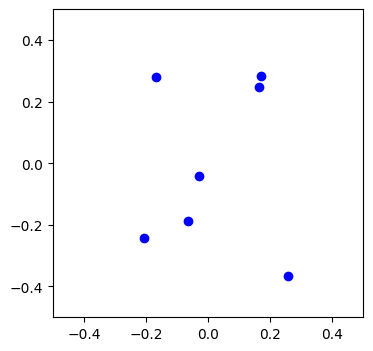

Epoch 56: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.17s/it]


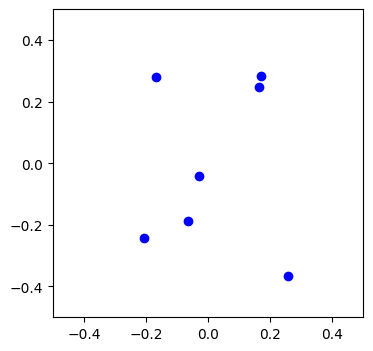

Epoch 57: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


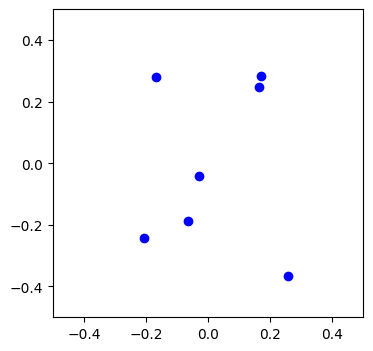

Epoch 58: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.20s/it]


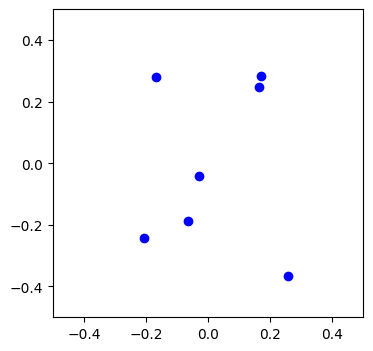

Epoch 59: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.22s/it]


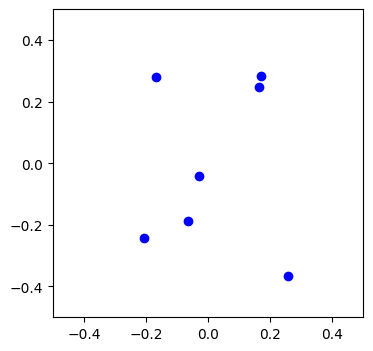

Epoch 60: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


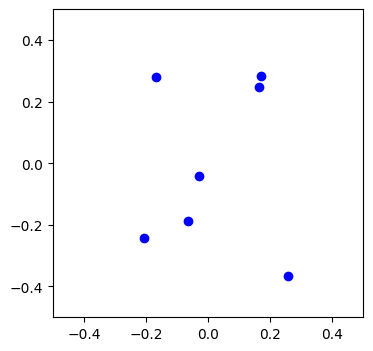

Epoch 61: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


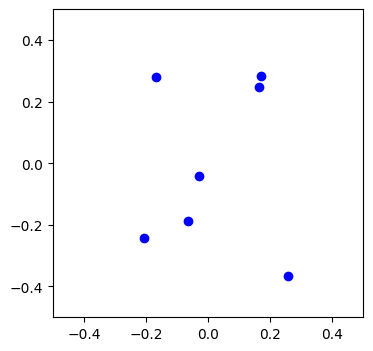

Epoch 62: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.19s/it]


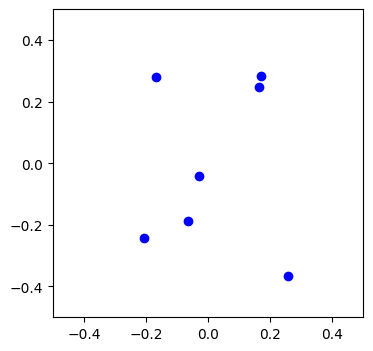

Epoch 63: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.40s/it]


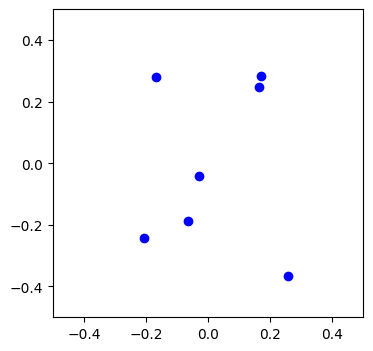

Epoch 64: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.36s/it]


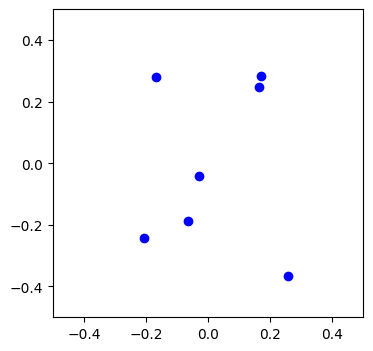

Epoch 65: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


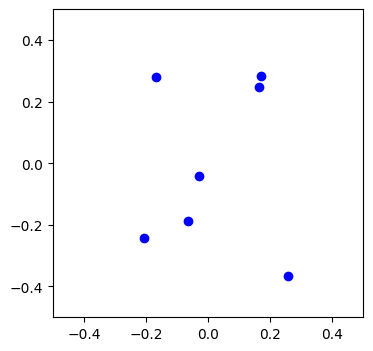

Epoch 66: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.42s/it]


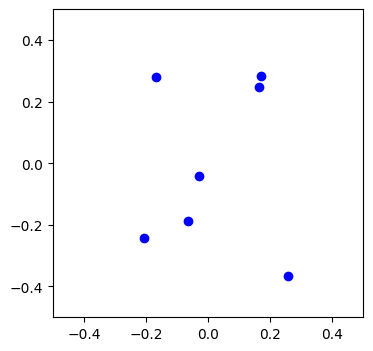

Epoch 67: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.35s/it]


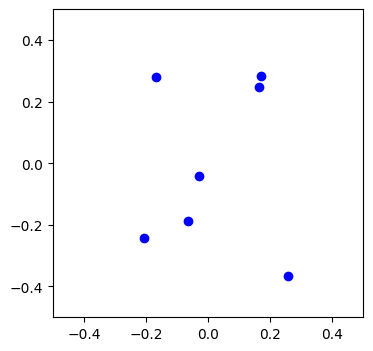

Epoch 68: Loss=0.000319


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.31s/it]


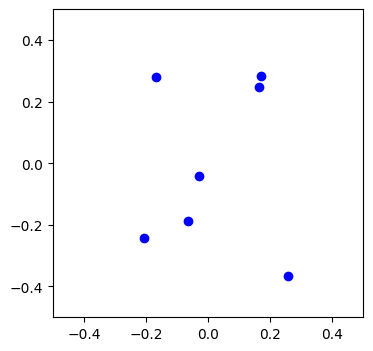

Epoch 69: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


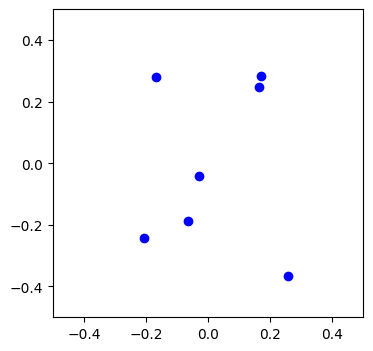

Epoch 70: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.35s/it]


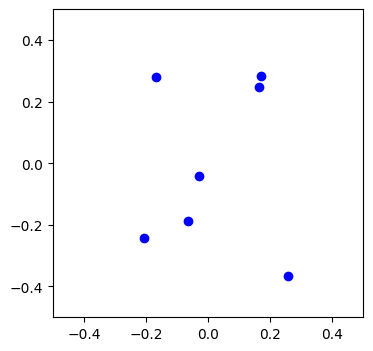

Epoch 71: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


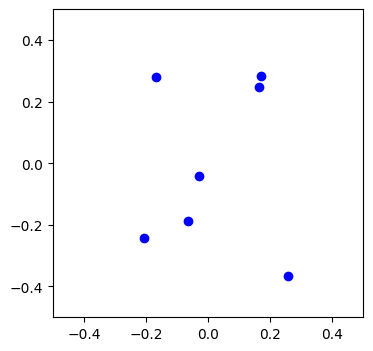

Epoch 72: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


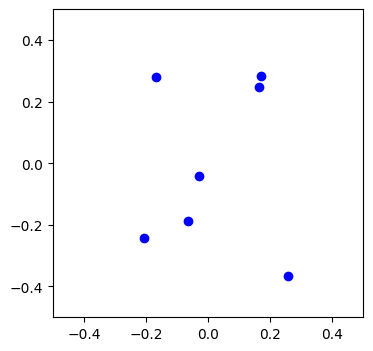

Epoch 73: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]


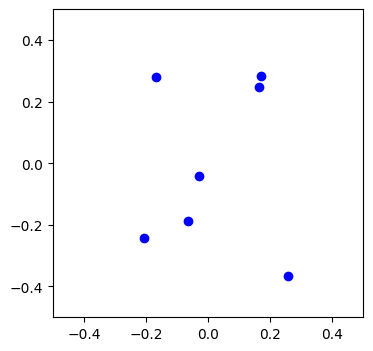

Epoch 74: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.30s/it]


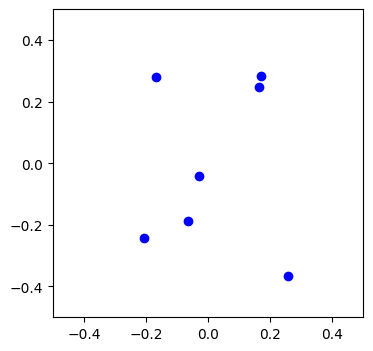

Epoch 75: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:11<00:00,  1.71s/it]


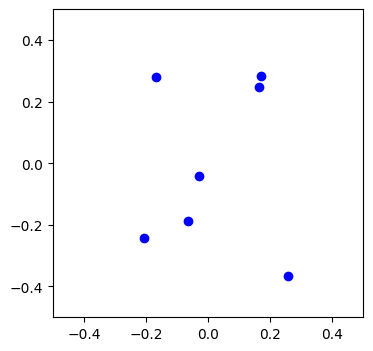

Epoch 76: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.35s/it]


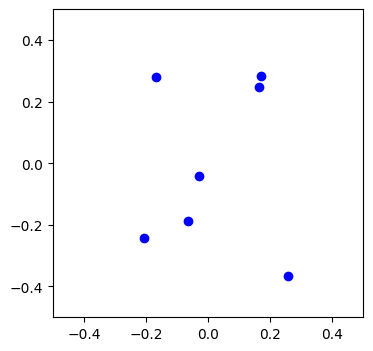

Epoch 77: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:10<00:00,  1.47s/it]


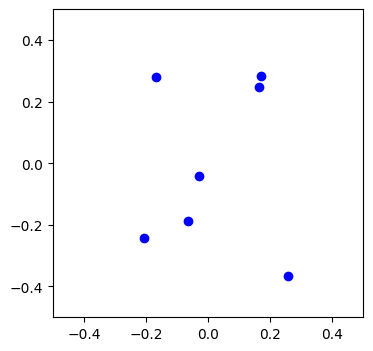

Epoch 78: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.41s/it]


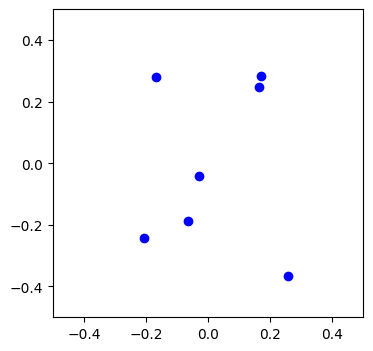

Epoch 79: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.42s/it]


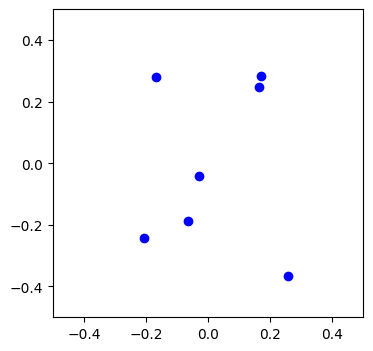

Epoch 80: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.41s/it]


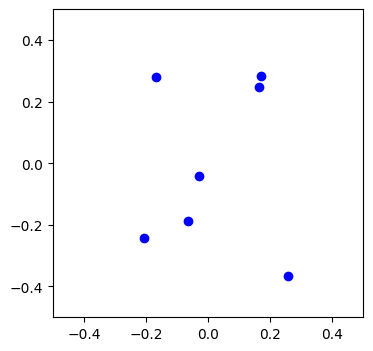

Epoch 81: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:10<00:00,  1.43s/it]


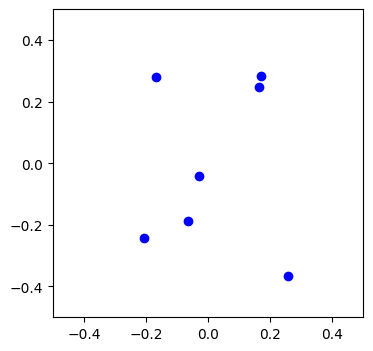

Epoch 82: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.38s/it]


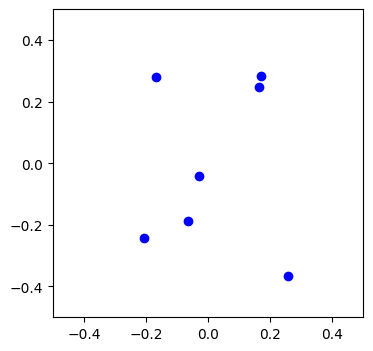

Epoch 83: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:10<00:00,  1.48s/it]


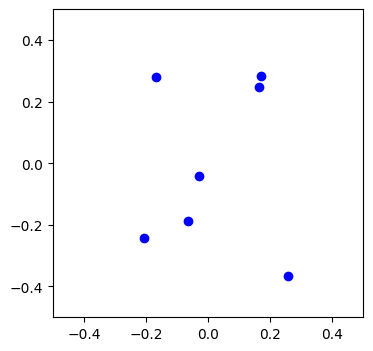

Epoch 84: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:10<00:00,  1.43s/it]


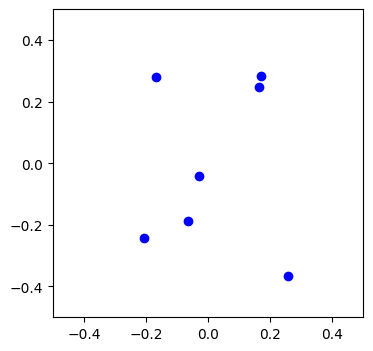

Epoch 85: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:11<00:00,  1.57s/it]


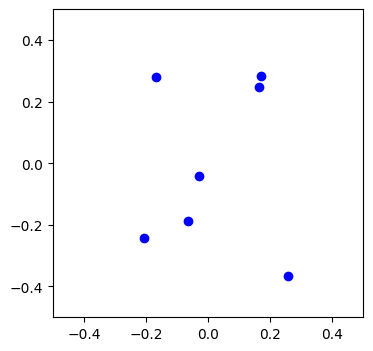

Epoch 86: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:10<00:00,  1.51s/it]


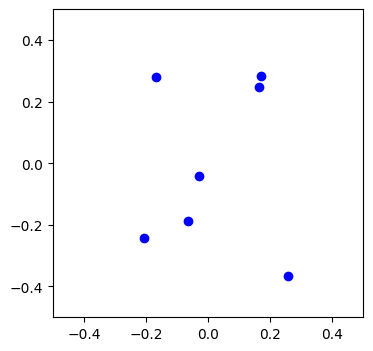

Epoch 87: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.40s/it]


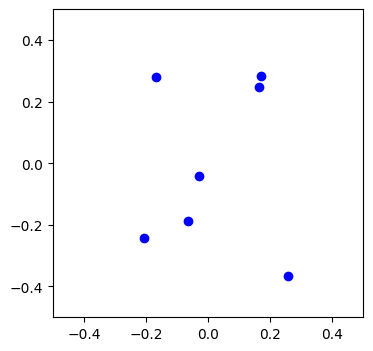

Epoch 88: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.39s/it]


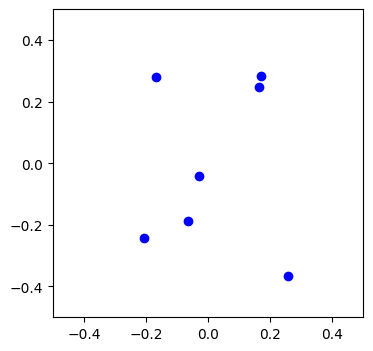

Epoch 89: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:10<00:00,  1.43s/it]


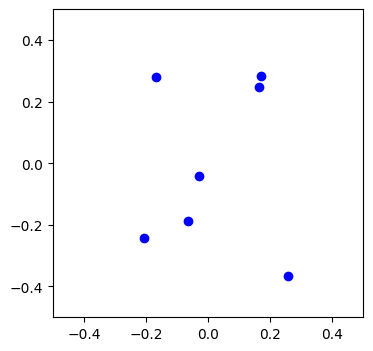

Epoch 90: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.34s/it]


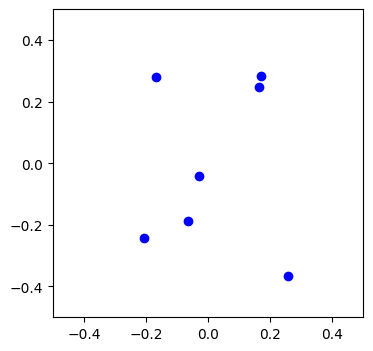

Epoch 91: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.32s/it]


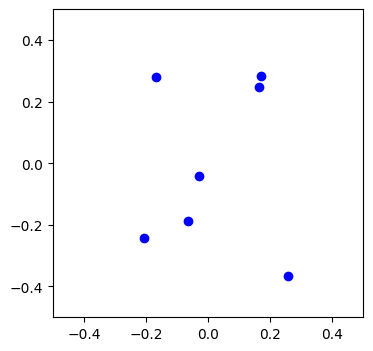

Epoch 92: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


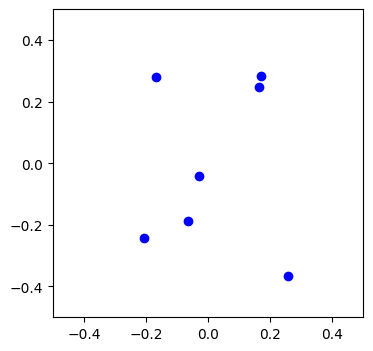

Epoch 93: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:10<00:00,  1.44s/it]


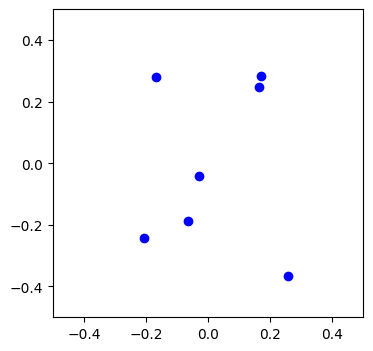

Epoch 94: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:10<00:00,  1.50s/it]


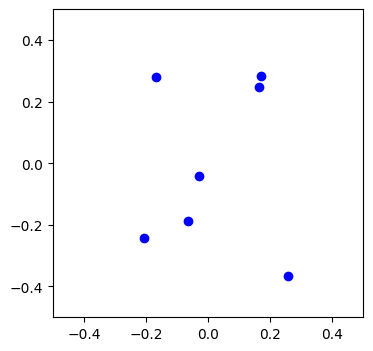

Epoch 95: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:10<00:00,  1.56s/it]


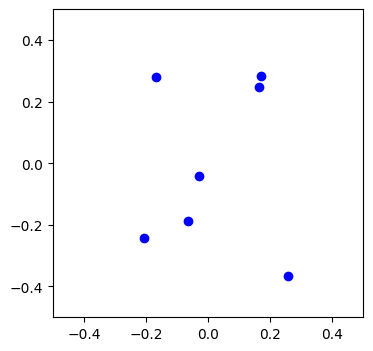

Epoch 96: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.26s/it]


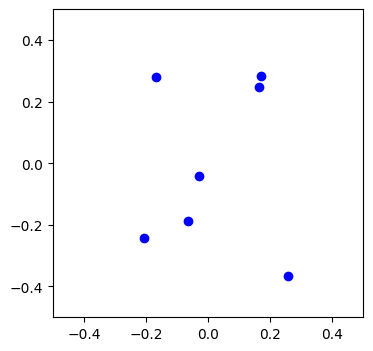

Epoch 97: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:08<00:00,  1.21s/it]


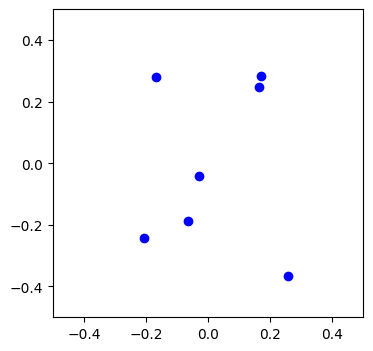

Epoch 98: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


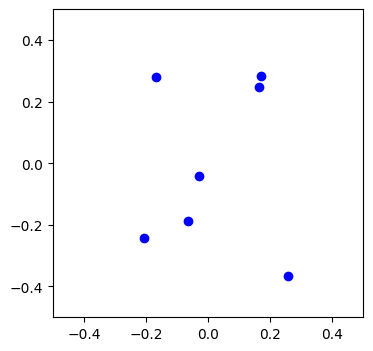

Epoch 99: Loss=0.000318


100%|█████████████████████████████████████████████| 7/7 [00:09<00:00,  1.29s/it]


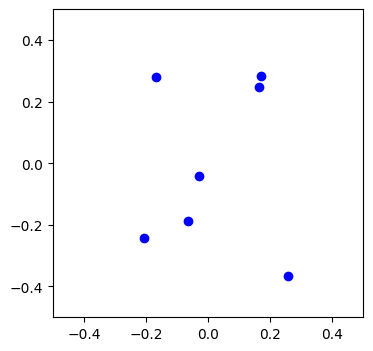

Epoch 100: Loss=0.000318


In [12]:
optimizer = torch.optim.Adam([ODEfunc.metric_field.masses_presoftplus], lr=0.01)
losses = []
masses_try = []

for epoch in range(0, 100):
    optimizer.zero_grad()              
    endpoints = []
    for i in tqdm(range(y0.shape[1])):
        single_y0 = y0[:, i:i+1]
        t_final, single_y = odeint_event(ODEfunc, single_y0, torch.tensor([0.0]), event_fn=terminate_func, reverse_time=False, odeint_interface=odeint)
        endpoints.append(single_y[1])
        
    y = torch.stack(endpoints, dim=1).squeeze()
    l = loss(target, y[0, :])
    plot_forward(y[0, :])
    
    
    l.backward()
    optimizer.step()
    masses_try.append(ODEfunc.metric_field.masses_presoftplus.detach().clone())
    losses.append(l.item())
    print(f"Epoch {epoch+1}: Loss={l:.6f}")

In [14]:
masses_try = np.array(masses_try)

In [ ]:
np.save(_AVOID_OVERWRITE_, masses_try)

In [16]:
masses_try2 = np.load("masses_try0121.npy")

In [17]:
delta = masses_try[0:100] - masses_try2[0:100]
delta_norm = np.square(delta)
delta_norm = np.sqrt(np.sum(delta_norm, axis=-1))

In [18]:
growth = delta_norm / delta_norm[0]

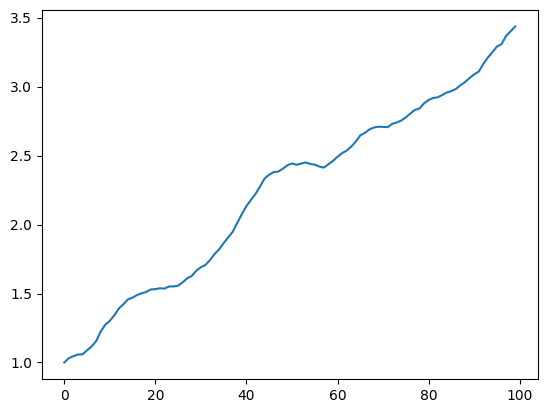

In [19]:
plt.plot(growth)

In [20]:
t = np.arange(len(growth)) + 1
exponent = np.log(growth) / t

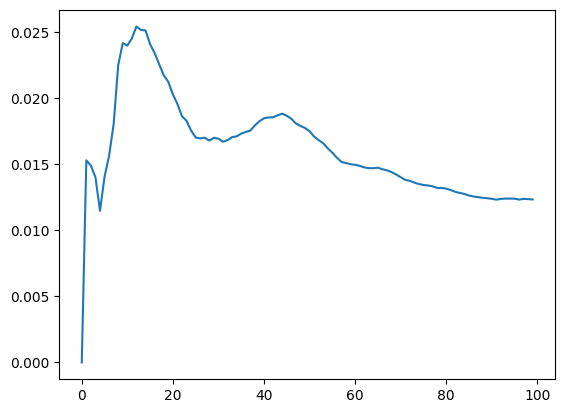

In [21]:
plt.plot(exponent)

## Loss Comparison

In [ ]:
RK4_loss = np.load("RK4_Comparison/losses1143.npy")
Adjoint_loss = [np.load("Model1_Aug9_1309.npz")['loss'][0:300], 
                np.load("Model1_Aug9_1556.npz")['loss'][0:300], 
                np.load("Model1_Aug10_0747.npz")['loss'][0:300]]

max_len = max(len(a) for a in Adjoint_loss)
padded = np.full((len(Adjoint_loss), max_len), np.nan)
for i, a in enumerate(Adjoint_loss):
    padded[i, :len(a)] = a
Adjoint_loss = np.nanmean(padded, axis=0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(1, 301)
fig, ax = plt.subplots(figsize=(10, 6))  

ax.plot(x, RK4_loss, color='r', label='Differentiation over Solver')
ax.plot(x, Adjoint_loss, color='b', label='Adjoint Sensitivity Method')

ax.set_yscale('log')
ax.grid(True, which="both", ls="-")

ax.legend()

plt.xlabel("Steps", loc="right", fontsize=12) 
plt.ylabel(r"$\mathcal{L}$", loc="top", fontsize=17, rotation=0, labelpad=-20) 


fig.savefig("loss_plot.pdf", format='pdf', bbox_inches='tight')

plt.show()

## FTLE Comparison

In [66]:
adaptive_traj = [np.load(f"Adaptive_FTLE/{fn}") for fn in os.listdir("Adaptive_FTLE/")]
rk4_traj = [np.load(f"RK4_FTLE//{fn}") for fn in os.listdir("RK4_FTLE//")]

In [68]:
def singleFTLE(traj1, traj2):
    traj1_100, traj2_100 = traj1[0:100], traj2[0:100]
    delta = traj1_100 - traj2_100
    delta_norm = np.square(delta)
    delta_norm = np.sqrt(np.sum(delta_norm, axis=-1))
    growth = delta_norm / delta_norm[0]
    t = np.arange(len(growth)) + 1
    exponent = np.log(growth) / t
    return exponent

In [92]:
adaptive_FTLEs = []
for i in range(len(adaptive_traj)):
    for j in range(i+1, len(adaptive_traj)):
        adaptive_FTLEs.append(singleFTLE(adaptive_traj[i], adaptive_traj[j]))
        
rk4_FTLEs = []
for i in range(len(rk4_traj)):
    for j in range(i+1, len(rk4_traj)):
        rk4_FTLEs.append(singleFTLE(rk4_traj[i], rk4_traj[j]))
        
adaptive_FTLEs = np.array(adaptive_FTLEs)
rk4_FTLEs = np.array(rk4_FTLEs)
adaptive_FTLE = np.sum(adaptive_FTLEs, axis=0) / len(adaptive_FTLEs)
rk4_FTLE = np.sum(rk4_FTLEs, axis=0) / len(rk4_FTLEs)

In [93]:
rk4_FTLE.shape

(100,)

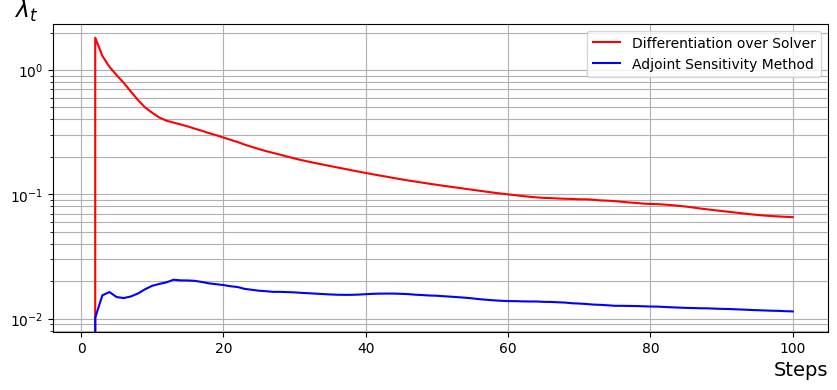

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(1, 101)
fig, ax = plt.subplots(figsize=(10, 4))  

ax.plot(x, rk4_FTLE, color='r', label='Differentiation over Solver')
ax.plot(x, adaptive_FTLE, color='b', label='Adjoint Sensitivity Method')

ax.set_yscale('log')
ax.grid(True, which="both", ls="-")

ax.legend()

plt.xlabel("Steps", loc="right", fontsize=14) 
plt.ylabel(r"$\lambda_t$", loc="top", fontsize=17, rotation=0, labelpad=-20) 


fig.savefig("FTLE.pdf", format='pdf', bbox_inches='tight')

plt.show()